# Introduction to sampling

**INM-6 Book club, 11 Oct 2019**<br>
**Alexandre René**

In [1]:
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import arviz as az
import theano
import theano.tensor as tt
import pymc3 as pm
import theano_shim as shim

from sampling_tutorial.utils import effective_n, SmoothClip, FlatLowerBound, FlatUpperBound
#from sampling_tutorial.utils import cDist, effective_n

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Hands-on preparation

    cd ~   # Or whatever directory you use for tutorials
    git clone https://github.com/alcrene/sampling-tutorial.git
    cd sampling-tutorial
    bash ./install.sh
    ./START

# Topics
- What is sampling it good for ?
- How does it work?
  + **Typical set**
  + Markov Chain Monte Carlo
    + **Transition invariance**
  + Nested sampling
- The classic sampler: Metropolis-Hastings algorithm
- What the cool kids do: Hamiltonian Monte Carlo
  + Standard algorithm
  + Automatically tuned version (NUTS)

# Material

<table>
  <tr>
    <td><em>Information Theory, Inference and Learning Algorithms</em> <br> (Mackay, 2003), Chaps 4, 29, 30</td><td><img width="200px" src="images/Mackay_cover.png"></td>
  </tr>
  <tr>
    <td><em><a href=https://arxiv.org/abs/1701.02434>A Conceptual Introduction to Hamiltonian Monte Carlo</a></em><br>(Betancourt, 2017)</td><td><img width="200px" src="images/A_conceptual_introduction_to_Hamiltonian_Monte_Carlo_abstract.png"></td>
  </tr>
  <tr>
    <td><em><a href=https://projecteuclid.org/euclid.ba/1340370944>Nested sampling for general Bayesian computation</a></em><br>(Skilling, 2006)</td><td><img width="200px" src="images/Nested_sampling_for_general_Bayesian_computation_abstract.png"></td>
  </tr>
</table>

# What is it good for ?
<img src=images/problems_to_be_solved.png width="600px">

- **Remark 1** It is sufficient to be able to compute $P$ up to a scaling factor. This is useful because often the normalization factor (*partition function*, or Bayesian *evidence*) is the hardest to compute.

- **Remark 2** Precisely because of Remark 1, it is not trivial to obtain the evidence from a Monte Carlo estimate.

## Monte Carlo estimate of expectations

Given a set of samples $x_i \sim P$, the expectation over $P$ can be approximated as
$$\begin{aligned}
Φ = \langle\phi(x)\rangle &= \int \mathrm{d}^N\!x\, P(x) \phi(x) \\
    &\approx \frac{1}{N} \sum_{i=1}^N \phi(x)
\end{aligned}$$

- **Remark 3** The accuracy of such a Monte Carlo estimate of depends only on the variance of $P$. In particular, it does **not depend the number of dimensions**.
- **Remark 4** Only **independent** samples "count".

# How does it work

## Typicality
Consider the following distribution and function $φ$.

In [2]:
from collections import Callable

class Function:
    def __init__(self, domain, image, domainlabel='x', funclabel='f'):
        if isinstance(image, Callable):
            image = image(domain)
        self.domain = domain
        self.image = image
        self.domainlabel = domainlabel
        self.funclabel = funclabel
    def plot(self, *args, include_zero=True, **kwargs):
        sns.set_style('ticks')
        ax = sns.lineplot(self.domain, self.image, *args, **kwargs)
        # Set x ticks
        xticks = [self.domain[0], self.domain[-1]]
        if np.prod(xticks) < 0:
            xticks.insert(1, 0)
        if include_zero:
            if np.min(self.image) > 0: ax.set_ylim(ymin=0)
            elif np.max(self.image) < 0: ax.set_ylim(ymax=0)
        ax.set_xticks(xticks)
        # Set y ticks
        ax.yaxis.set_major_locator(plt.MaxNLocator(3))
        # Despine
        sns.despine(ax=ax, trim=True)
        # Set labels
        ax.set_xlabel(f"${self.domainlabel}$")
        ax.text(0.9, 0.9, f"${self.funclabel}({self.domainlabel})$",
                fontsize=14,
                ha='right', transform=ax.transAxes)
        return ax
    
class PDF(Function):
    def __init__(self, domain, pdf, domainlabel='x', funclabel='P'):
        super().__init__(domain, pdf, domainlabel, funclabel)
        self.image /= np.trapz(self.image, self.domain)

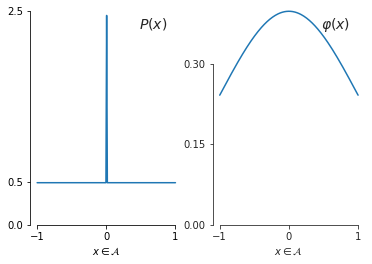

In [3]:
plt.subplot(121)
x = np.linspace(-1, 1, 200)
p = np.ones(x.shape); p[100] = 5
ax = PDF(x, p).plot();
ax.set_xlabel('$x \in \mathcal{A}$');
ax.set_yticks([0, 0.5, 2.5])
sns.despine(trim=True)

plt.subplot(122)
ax = Function(x, stats.norm().pdf, funclabel='φ').plot();
ax.set_xlabel('$x \in \mathcal{A}$');

When evaluating $\int_\mathcal{A} P(x) φ(x) dx$, what matters most:
- The most likely value ($x=0$) ?
- Or the set of points $\left\{x : P(x) = 0.5\right\}$ ?

## Typicality

Another example: Consider $N$ binary random variables (spins, 0-1, coin flips, whatever) with $p_\uparrow = 1/3$ and $p_\downarrow = 2/3$.
- The most likely state is to have all spins $\uparrow$.
- But the most "typical" state is to have 1/3 $\uparrow$, 2/3 $\downarrow$.

## Typical set

Let $H$ be the average information content of a single event $\left(H = \sum_i p_i \log_2 \frac{1}{p_i}\right)$ and $N$ the number of events. The ensemble of events in the **typical set** are those whose *surprise* is within a distance $β$ of $NH$:

$$T = \left\{ x \in \mathcal{A} : \left\lvert \frac{1}{N} \log_2 \frac{1}{P(x)} - H \right\rvert < β \right\}$$

<p style="text-align:right; text-color:gray">c.f. Mackay §4.4</p>

In [8]:
XX, YY = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))
XY = np.stack((XX, YY), axis=2)

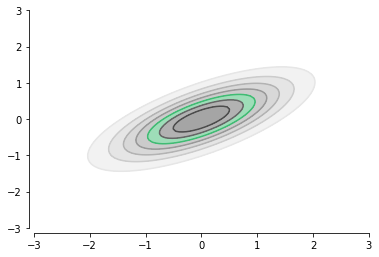

In [3]:
n = 8
c = list(np.broadcast_to(1-np.arange(n)*0.8/n, (3,n)).T)
c[-3] = '#3fbc73'
ZZ = stats.multivariate_normal(mean=[0,0], cov=[[1, 0.5],[0.5, 0.5]]).pdf(XY)
plt.contourf(XX, YY, ZZ, levels=8, colors=c, alpha=0.5)
plt.contour(XX, YY, ZZ, levels=8, colors=c)
sns.despine(trim=True, offset=5)

In [27]:
def cDist_pure_numpy:
    """Easier to play around with than the PyMC3 model."""
    n = 2
    def f(x, c):
        return np.stack((x[...,0]**2 - x[...,1]**2, 2*x[...,0]*x[...,1]), axis=-1) + c
    bound = SmoothClip(4.)
    flatten_at_zero = FlatLowerBound(0, .001)
    def p(c):
        c = np.array(c); x = np.zeros(2)
        for i in range(n):
            x = f(x, c)
        def norm(x):
            # return np.linalg.norm(x, axis=-1)
            return np.sum(abs(x), axis=-1)
        return np.exp((bound.high - bound(flatten_at_zero(norm(x))))**1.5)
        #return np.log(np.linalg.norm(x, axis=-1))
    return p

In [28]:
ZZ = pd.DataFrame(p(XY),
                  index=np.round(XX[0,:], 3), columns=np.round(YY[:,0], 3))

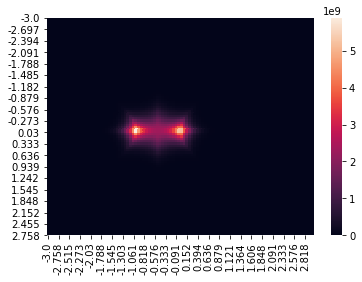

In [29]:
sns.heatmap(ZZ, vmin=0)

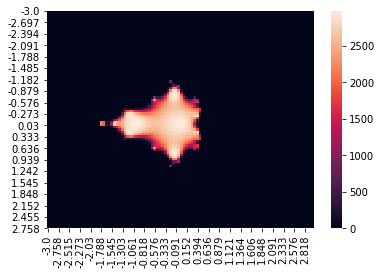

In [53]:
sns.heatmap(ZZ, vmin=0)

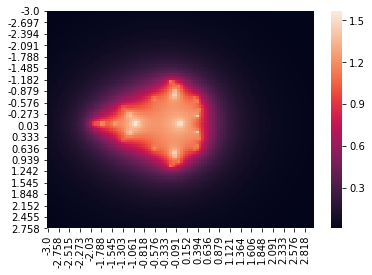

In [77]:
sns.heatmap(np.exp(0.1)*ZZ)

# Sampling algorithms

To illustrate sampling algorithms, I will use a distribution defined as follows:

- Take $c, x \in \mathbb{R}^2$ and $f(x) = \begin{pmatrix}x_0^2 - x_1^2 \\ 2 x_0 x_1\end{pmatrix} + c \,.$
- Define $\mathcal{D}_n(s)$ to be the distribution with the p.d.f. proportional to :
    $$p(c) \propto \bigl\lfloor M - \lVert \underbrace{f( \dotso f}_{\text{$n$ times}}(s)\dotso)\rVert_1 \bigr\rfloor_+$$

We set $s = \begin{pmatrix}0\\0\end{pmatrix}$ for now.

In [22]:
with pm.Model() as known_model:
    c = cDist('c', n=2, s=(0.,0.))

<span style="color: #888888">(<code style="color: #888888">cDist</code> is imported from <code style="color: #888888">sampling_tutorial.utils</code>)</span>

In [9]:
_truedist = cDist.logp(cDist.dist(n=2, s=(0.,0.)), XY)
truedist = pd.DataFrame(np.exp(_truedist - _truedist.max()),
                        index=np.round(XX[0,:], 3), columns=np.round(YY[:,0], 3))

NameError: name 'XY' is not defined

In [23]:
known_model

In [18]:
ndraws = 40000

## Metropolis-Hastings MCMC

In [32]:
with known_model:
    Metropolis_trace = pm.sample(draws=ndraws, init='jitter+adapt_diag', chains=4,
                                 step=pm.Metropolis())

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [z]
Sampling 2 chains: 100%|██████████| 201000/201000 [00:18<00:00, 10841.53draws/s]
The number of effective samples is smaller than 25% for some parameters.


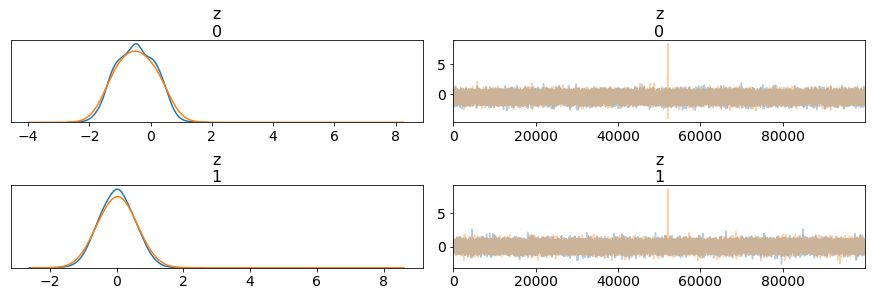

In [33]:
pm.traceplot(Metropolis_trace);

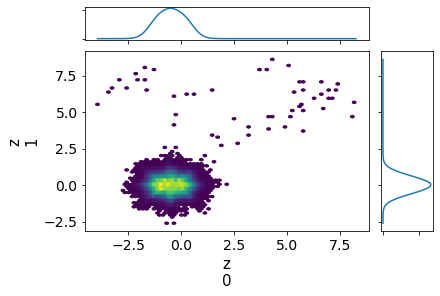

In [34]:
az.plot_joint(Metropolis_trace, kind='hexbin');

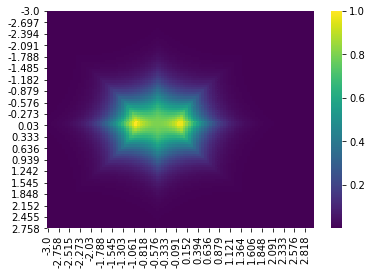

In [10]:
sns.heatmap(truedist, cmap='viridis')

In [111]:
effective_n(Metropolis_trace)

,effective sample size
$z_0$,24400
$z_1$,28300


### Properties of Metropolis-Hastings

- Random-walk behaviour
- 

## Hamiltonian Monte Carlo

In [19]:
with known_model:
    HMC_trace = pm.sample(draws=ndraws, init='jitter+adapt_diag', chains=4,
                          step=pm.HamiltonianMC())

Multiprocess sampling (4 chains in 2 jobs)
HamiltonianMC: [c]
Sampling 4 chains: 100%|██████████| 162000/162000 [00:42<00:00, 3822.86draws/s]
The number of effective samples is smaller than 25% for some parameters.


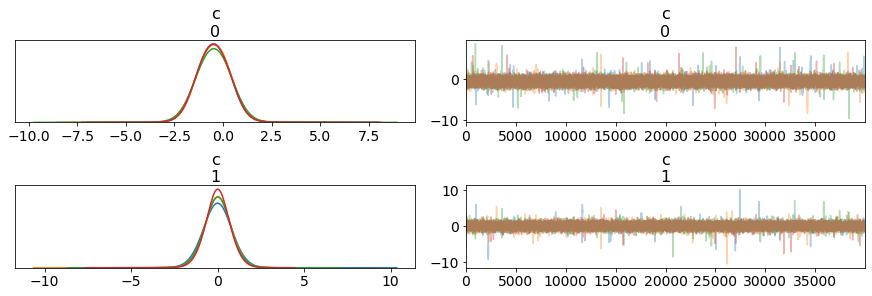

In [20]:
pm.traceplot(HMC_trace);

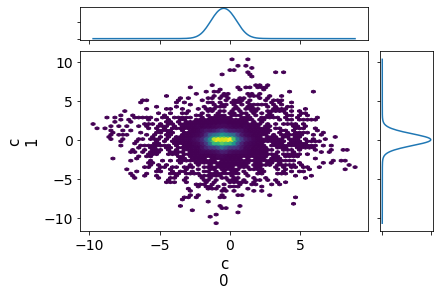

In [21]:
az.plot_joint(HMC_trace, kind='hexbin');

In [17]:
effective_n(HMC_trace)

NameError: name 'RoundToSigFigs' is not defined

## Auto-tuned Hamiltonian Monte Carlo – NUTS

In [128]:
with known_model:
    NUTS_trace = pm.sample(draws=ndraws, init='jitter+adapt_diag', chains=4,
                          step=pm.NUTS())

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [z]
Sampling 2 chains: 100%|██████████| 201000/201000 [01:55<00:00, 1739.98draws/s]


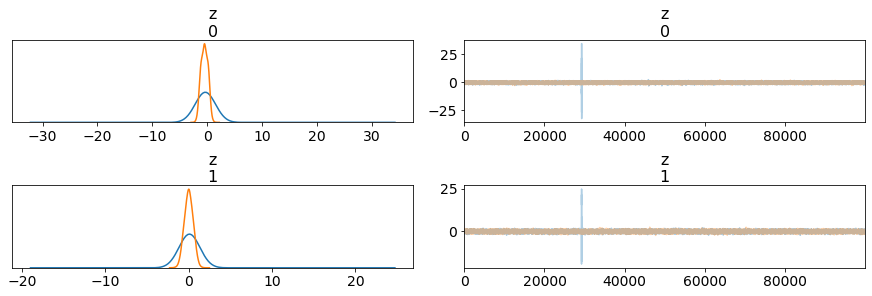

In [132]:
pm.traceplot(NUTS_trace);

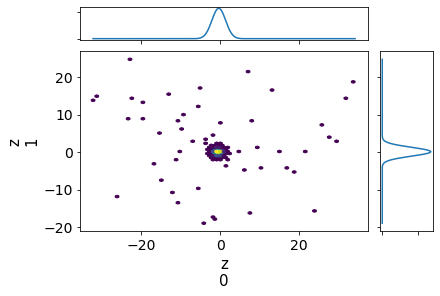

In [136]:
az.plot_joint(NUTS_trace, kind='hexbin');

In [135]:
effective_n(NUTS_trace)

,effective sample size
$z_0$,86500
$z_1$,93300


# Inference example

In [22]:
L = len(HMC_trace)
data = np.zeros((L*HMC_trace.nchains, 2))
for i, strace in enumerate(HMC_trace._straces.values()):
    data[i*L:(i+1)*L] = strace.samples['c']

In [32]:
data = data[::len(data)//1000]

In [33]:
with pm.Model() as unknown_model:
    s = pm.Normal(name='s', mu=np.array([0,0]), sd=np.array([10,10]), shape=(2,))
    c = cDist(name='c_u', n=2, s=s, observed=data)

In [34]:
unknown_model

In [35]:
with unknown_model:
    HMC_infer_trace = pm.sample(draws=1000, init='jitter+adapt_diag', chains=4,
                          step=pm.HamiltonianMC())

Multiprocess sampling (4 chains in 2 jobs)
HamiltonianMC: [s]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:04<00:00, 1281.51draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


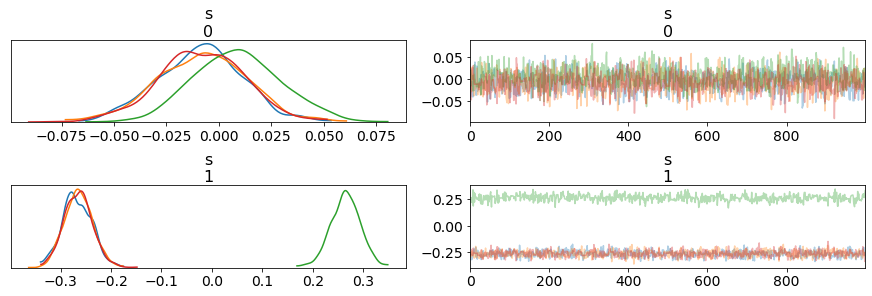

In [36]:
pm.traceplot(HMC_infer_trace);

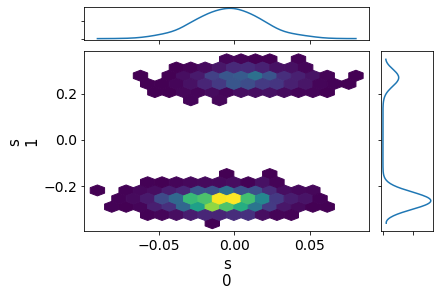

In [37]:
az.plot_joint(HMC_infer_trace, kind='hexbin');

In [135]:
effective_n(HMC_infer_trace)

,effective sample size
$z_0$,86500
$z_1$,93300


# Dealing with gnarly distributions

What makes a distribution difficult to sample ?
- Multiple modes
- Varying curvature
- Generally, the less Gaussian-like, the harder it is

MCMC trick:
- Reparameterize to make the distribution more Gaussian like

Particle-based sampling:
- Sequential Monte Carlo
- Nested sampling – no MCMC at all (Skilling 2006)